In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool

Note: When doing CV and standardizing, don't include testing data when calculating mean and sd since that causes the testing data to influence the training data. Just take mean and sd of training and standardize both training and testing using those. 


# Homework (Lecture 5)

## Problem 1

In [ ]:
def load_data():
    df = pd.read_csv('boston.csv')
    X = df.drop(['ZN','CHAS','MEDV'],axis=1)
    Y = np.log10(df['MEDV'])
    return X,Y

def calc_ahat(X,Y,n,j,betas):
    prod = (Y - sum(X.drop(X.columns[j], axis=1) @ np.delete(betas,j)))
    a_hat = (1/n) * sum(X.iloc[:,j] * prod)
    return a_hat
    
def calc_betaj(X,Y,n,j,betas,lambda_):
    a_hat = calc_ahat(X,Y,n,j,betas)
    sign = np.sign(a_hat)
    max_right = max(np.abs(a_hat) - (n/2)*lambda_,0)
    beta_hat_j = sign * max_right
    return beta_hat_j

def lasso(X,Y,lambda_,epsilon=1e-6):
    n = X.shape[0]
    p = X.shape[1]
    betas = np.random.normal(size=p)
    err = 1
    while err > epsilon:
        last_beta = betas.copy()
        for j in np.arange(p):
            betas[j] = calc_betaj(X,Y,n,j,betas,lambda_)
        err = np.sum(np.abs(betas-last_beta))
    return betas

def normalize(df):
    return (df - df.mean())/df.std()
    
def train_test_split(X,Y,folds,i):
    temp = folds[:]
    testing_idx = temp.pop(i)
    training_idx = np.concatenate(temp)
    X_train, X_test, Y_train, Y_test = X.iloc[training_idx,:], X.iloc[testing_idx,:], Y.iloc[training_idx,], Y.iloc[testing_idx,]
    X_train = normalize(X_train)
    X_train['const'] = 1
    X_test = normalize(X_test)
    X_test['const'] = 1
    return X_train, X_test, Y_train, Y_test

def sse(predicted,actual):
    return sum((predicted - actual) ** 2)

def cv(lambda_,k=5):
    X,Y = load_data()
    n = X.shape[0]
    # creating indices for folds
    folds = []
    remaining_idx = np.arange(n)
    for i in np.arange(k):
        indices = np.random.choice(remaining_idx,round(n * 1/k), replace=False)
        remaining_idx = np.setdiff1d(remaining_idx, indices)
        folds.append(indices)
        
    # calculating total error
    total_error = 0
    for i,_ in enumerate(folds):
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,folds,i)
        betas = lasso(X_train,Y_train,lambda_)
        predicted = X_test @ betas
        error = sse(predicted,Y_test)
        total_error += error
    return (betas, lambda_, total_error)

In [2]:
from multiprocessing import cpu_count
max_cpu = cpu_count()

In [ ]:
#%%timeit
lambdas = np.linspace(0,1e-3,1000)
with ThreadPool(max_cpu - 1) as pool:
    output = pool.map(cv,lambdas)

In [ ]:
betas = []
lambdas = []
errors = []

for b,l,err in output:
    betas.append(b)
    lambdas.append(l)
    errors.append(err)
    
plt.figure(figsize=[8,5])
plt.scatter(x = lambdas, y = errors)

In [ ]:
prob_1_results = pd.DataFrame({'Betas':betas,'Lambda':lambdas,'Errors':errors}).sort_values(by='Errors')

In [ ]:
prob_1_results['Betas'].values[0]

In [ ]:
prob_1_results['Lambda'].values[0]

In [ ]:
prob_1_results['Errors'].values[0]

## Problem 2

### Part (a)

In [3]:
def DGP(k=5):
    '''
    Generates sparse data with explanatory variable of interest D, potentially relevant covariates W
    and outcome Y.
    
    Parameter:
        k (int): determines number of relevant controls
        
    Returns D, W, X, and Y where X is just D concatenated with W
    '''
    W_relevant = np.random.rand(200,k) + 1
    W_noise = np.random.rand(200,50-k) * np.random.normal(scale=3,size=50-k)
    W = np.concatenate((W_relevant,W_noise),axis=1)
    D = np.random.rand(1,200).reshape(-1,1) + (W_relevant @ (np.random.poisson(2.2,size=k) + 1)).reshape(200,1)
    Y = (D * 3 + (W_relevant @ np.ones(k)).reshape(200,1)  + np.random.normal(size=200).reshape(200,1)).flatten()
    X = np.concatenate((D,W),axis=1)
    return D,W,X,Y

### Part (b)

In [64]:
from sklearn.linear_model import LinearRegression, LassoCV
import cvxpy as cp

ModuleNotFoundError: No module named 'cvxpy'

In [5]:
def np_standardize(arr):
    return (arr - np.mean(arr,axis=0))/np.std(arr,axis=0)

def OLS(X,Y):
    ols = LinearRegression().fit(X,Y)
    beta_1 = ols.coef_.flatten()[0]
    return beta_1

def Lasso(X,Y):
    X = np_standardize(X)
    lasso = LassoCV().fit(X,Y)
    beta_1 = lasso.coef_.flatten()[0]
    return beta_1

def Dantzig(X,Y):
    X = np_standardize(X)
    n = X.shape[0]
    p = X.shape[1]
    lambda_ = np.sqrt((2 * np.log(p)) / n)
    
    betas = cp.Variable(p)
    objective = cp.Minimize(cp.norm1(betas))
    constraints = [cp.abs((1/n) * cp.sum(cp.multiply(X[:,j], (Y - X @ betas)))) <= lambda_ for j in range(p)]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return betas.value[0]

def Post(X,Y):
    # variable selection
    X_standard = np_standardize(X)
    lasso = LassoCV()
    lasso.fit(X_standard,Y)
    var_select = [i for i, coef in enumerate(lasso.coef_.flatten()) if coef != 0]
    X_select = X[:,var_select]
    
    # OLS
    beta1 = OLS(X_select,Y)
    return beta1

def Double(D,W,X,Y):
    X_standard = np_standardize(X)
    W_standard = np_standardize(W)
    # obtain gamma
    lasso1 = LassoCV().fit(W_standard,D.flatten())
    gamma = lasso1.coef_
    
    # beta1, beta2
    lasso2 = LassoCV().fit(X_standard,Y)
    beta_1 = lasso2.coef_.flatten()[0]
    beta_2 = lasso2.coef_.flatten()[1:]
    
    # estimation
    n = X.shape[0]
    num = (1/n) * (np.sum((Y - W @ beta_2) * (D.flatten() - W @ gamma)))
    denom = (1/n) * (np.sum(D.flatten() * (D.flatten() - W @ gamma)))
    beta_DL = num / denom
    return beta_DL

### Part (c)

In [6]:
def get_betas(D,W,X,Y):
    beta_ols = OLS(X,Y)
    beta_lasso = Lasso(X,Y)
    beta_dantzig = Dantzig(X,Y)
    beta_post = Post(X,Y)
    beta_double = Double(D,W,X,Y)
    return beta_ols, beta_lasso, beta_dantzig, beta_post, beta_double

def sim(i):
    D,W,X,Y = DGP()
    betas = get_betas(D,W,X,Y)
    return betas

In [7]:
with ThreadPool(max_cpu - 1) as pool:
    output = pool.map(sim,np.arange(200))

In [11]:
prob2_results = pd.DataFrame(np.array(output),columns = ['OLS', 'Lasso', 'Dantzig','Post-Lasso','Double-Lasso'])

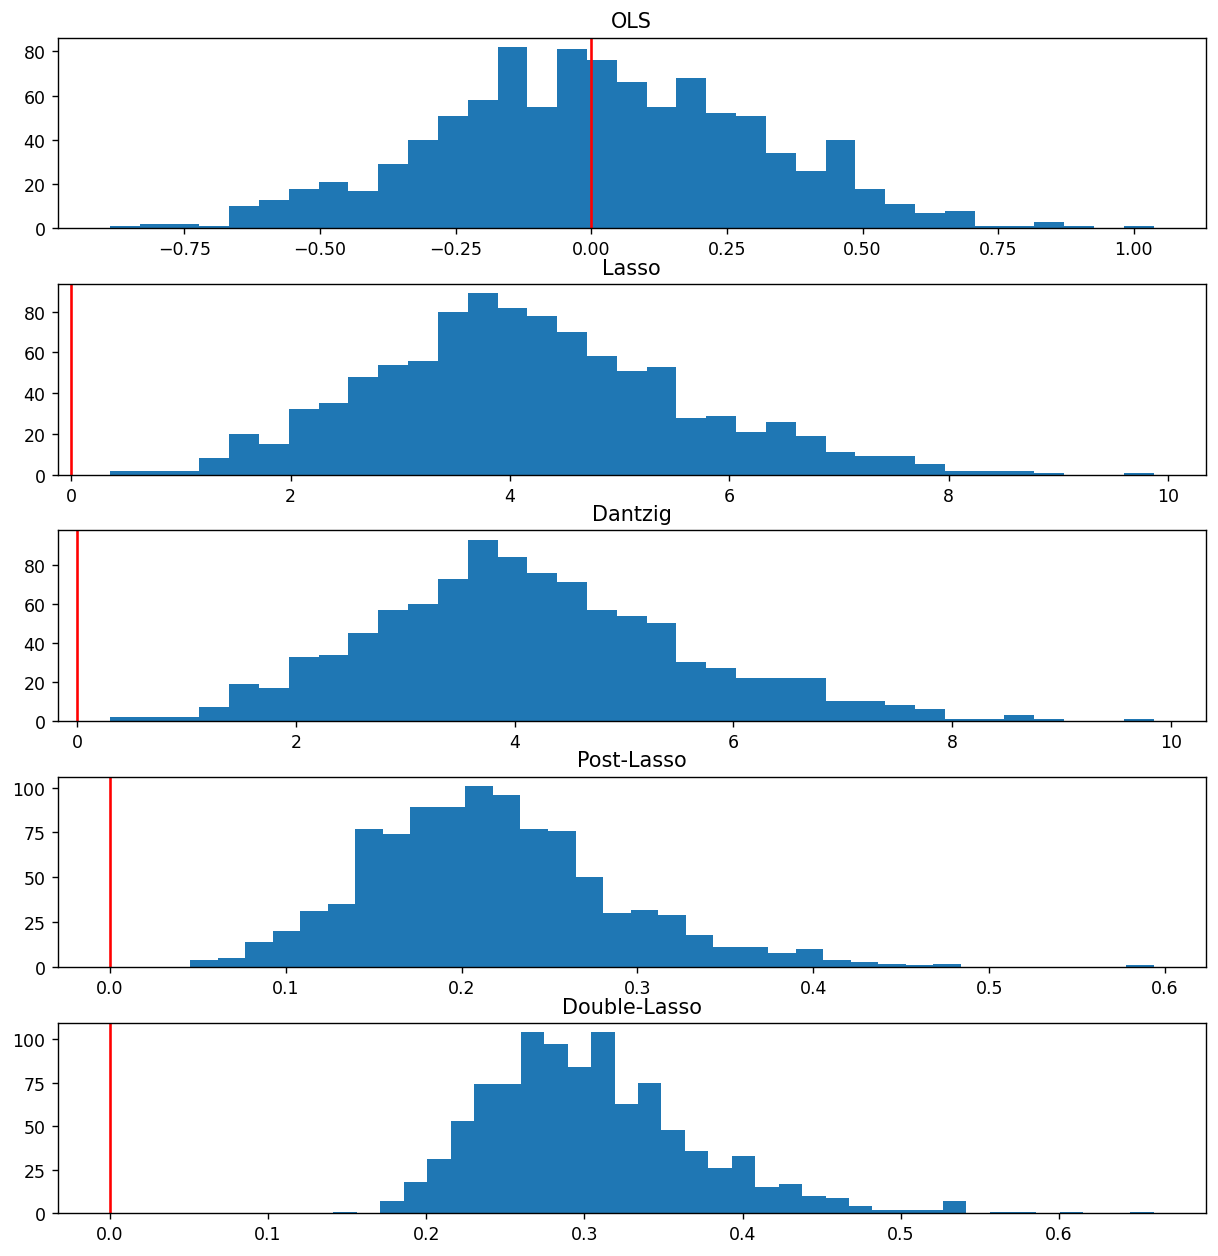

In [26]:
fig, ax = plt.subplots(nrows=prob2_results.shape[1])
fig.set_size_inches((10,10))
fig.set_dpi(125)
fig.tight_layout()
for i,name in enumerate(prob2_results.columns):
    ax[i].hist(prob2_results[name]-3,bins=35)
    ax[i].axvline(color='red')
    ax[i].set_title(name)

# Homework (Lecture 6)

## Problem 1

### Part (1)

In [33]:
X = np.array(([1,0.8,0,0],[0.8,1,0,0],[0,0,1,0.5],[0,0,0.5,1]))
print(np.linalg.eig(X))
V = np.linalg.svd(X)[2].T
v_1 = V[:,0]
U_1 = X @ v_1
v_2 = V[:,1]
U_2 = X @ v_2

(array([1.8, 0.2, 1.5, 0.5]), array([[ 0.70710678, -0.70710678,  0.        ,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        , -0.        ,  0.70710678, -0.70710678],
       [ 0.        , -0.        ,  0.70710678,  0.70710678]]))


In [38]:
np.linalg.eig(X)[1].T

array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [-0.70710678,  0.70710678, -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [ 0.        ,  0.        , -0.70710678,  0.70710678]])

In [36]:
np.linalg.svd(X)[2].T

array([[-0.70710678, -0.        ,  0.        , -0.70710678],
       [-0.70710678, -0.        ,  0.        ,  0.70710678],
       [-0.        , -0.70710678, -0.70710678,  0.        ],
       [-0.        , -0.70710678,  0.70710678,  0.        ]])

In [23]:
U_1

array([-1.27279221, -1.27279221,  0.        ,  0.        ])

In [24]:
U_2

array([ 0.        ,  0.        , -1.06066017, -1.06066017])

In [25]:
print(U_2 @ U_1)

0.0


### Part (2)

Yes, the result seems intuitive because much of the variance appears to be in the first two components of the covariance matrix.

### Part (3)

In [26]:
v_3 = V[:,2]
U_3 = X @ v_3
v_4 = V[:,3]
U_4 = X @ v_4

In [27]:
print(U_3 @ U_2)
print(U_3 @ U_1)

print(U_4 @ U_3)
print(U_4 @ U_2)
print(U_4 @ U_1)

-1.1102230246251565e-16
0.0
0.0
0.0
0.0


### Part (4)

In [39]:
V = np.linalg.eig(X)[1]

In [40]:
U = X @ V

In [41]:
U

array([[ 1.27279221, -0.14142136,  0.        ,  0.        ],
       [ 1.27279221,  0.14142136,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.06066017, -0.35355339],
       [ 0.        ,  0.        ,  1.06066017,  0.35355339]])

In [ ]:
Z = YX

In [ ]:
AZ = Y U = X V Y 

## Problem 2

In [65]:
from sklearn.linear_model import LinearRegression

In [101]:
n=200
p=50
k=5

In [168]:
def factor_dgp(k,n=200,p=50):
    mu = np.array([np.random.uniform(low=0,high=10,size=k) for _ in np.arange(n)])
    f = np.array([np.random.normal(1,2,size=k) for _ in np.arange(p)]).reshape(k,p)
    W = mu @ f
    D = np.where(W[:,5] > -5,1,0).reshape(200,1)
    Z = W + np.array([np.random.normal(0,10,size=p) for _ in np.arange(n)])
    Y = (5 * D + W @ (3 * np.ones((50,1))) + np.random.normal(0,250)).flatten()
    return Y,D,W,Z

def ols(Y,D,W):
    X = np.concatenate((D,W),axis=1)
    ols = LinearRegression().fit(X,Y)
    beta_1 = ols.coef_.flatten()[0]
    return beta_1

def double_pcr(Y,D,Z):
    f = np.linalg.svd(Z)[2].T[:,:k]
    mu = (Z @ f)[:,:k]
    w_hat = mu @ f.T
    ols1 = LinearRegression().fit(np.concatenate((D,w_hat),axis=1),Y)
    beta_2 = ols1.coef_.flatten()[1:]
    ols2 = LinearRegression().fit(w_hat,D.flatten())
    gamma = ols2.coef_.flatten()
    
    num = (Y - w_hat @ beta_2) * (D.flatten() - w_hat @ gamma)
    denom = D.flatten() * (D.flatten() - w_hat @ gamma)
    beta_1 = sum(num) / sum(denom)
    return beta_1

In [169]:
k=5
Y,D,W,Z = factor_dgp(k,n=200,p=50)
double_pcr(Y,D,Z)

370.0748299270723